<a href="https://colab.research.google.com/github/Frederick-Stein/Data-Science-Playground/blob/main/DataPreparation_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import pandas as pd
import random
from tqdm import tqdm ## progress bar
from torchvision import transforms, datasets
from tqdm import tqdm ## progress bar

import requests
import zipfile
from pathlib import Path
import os
from PIL import Image

In [ ]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
print(image_path)

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi
data/pizza_steak_sushi directory exists.


In [ ]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 files in 'data/pizza_steak_sushi'.
There are 3 directories and 0 files in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 files in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 files in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 files in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 files in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 files in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 files in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 files in 'data/pizza_steak_sushi/test/sushi'.


Random image path: data/pizza_steak_sushi/train/steak/1976160.jpg
Random image label: steak
Image size: 512 * 512


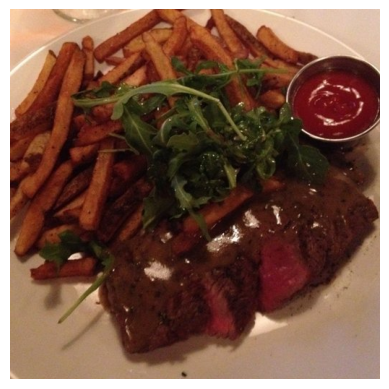

In [ ]:
## Get a random image
image_path_list = list(image_path.glob('*/*/*.jpg'))

random_image_path = random.choice(image_path_list)
random_imgae_label = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Random image label: {random_imgae_label}")
print(f"Image size: {img.height} * {img.width}")
plt.imshow(img)
plt.axis(False)  # Hide axes
plt.show()

Image size: torch.Size([128, 128, 3])


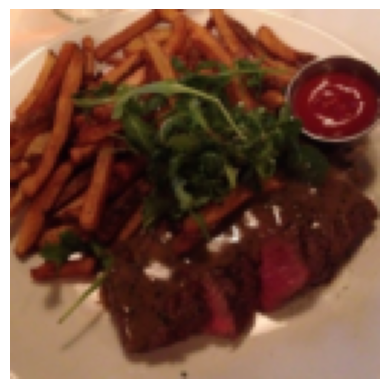

Using device: cpu


In [ ]:
# Write transform for image
train_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(128, 128)),
    # # Flip the images randomly on the horizontal
    # transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance

    # More data augmentation
    transforms.TrivialAugmentWide(num_magnitude_bins=31),

    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()
])
transformed_image = train_transform(img).permute(1, 2, 0)
print(f"Image size: {transformed_image.shape}")
plt.imshow(transformed_image)
plt.axis(False)  # Hide axes
plt.show()


# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

In [ ]:
# prepare train and test data
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)
class_names = train_data.classes
print(class_names)

Batch_size = 64
num_cpus = os.cpu_count()
train_loader = DataLoader(train_data, batch_size = Batch_size, num_workers=num_cpus, shuffle = True)
test_loader = DataLoader(test_data, batch_size = Batch_size, num_workers=num_cpus, shuffle = False)

['pizza', 'steak', 'sushi']


In [ ]:
def conv_block(in_ch, out_ch):

    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, 1, 1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
        nn.Conv2d(out_ch, out_ch, 3, 1, 1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )



class CNN(nn.Module):

    def __init__(self, in_ch, hidden_ch, out_ch, fc_ch = 256, drop = 0.2):
        super().__init__()
        self.block1 = conv_block(in_ch, hidden_ch)
        self.block2 = conv_block(hidden_ch, hidden_ch * 2)
        self.block3 = conv_block(hidden_ch * 2, hidden_ch * 4)

        # Fix the size of output
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(drop),
            nn.Linear(hidden_ch * 4, fc_ch),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(fc_ch, out_ch)
            )


        # self.classifier = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(hidden_ch * 16 * 16, out_ch)
        # )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

In [ ]:
torch.manual_seed(42)
image, label = next(iter(train_data))
print(image.shape)
len(class_names)
image = image.unsqueeze(0)
model = CNN(3, 32, len(class_names), 256)
model(image)

torch.Size([3, 128, 128])


tensor([[-0.1596,  0.1218,  0.3036]], grad_fn=<AddmmBackward0>)

In [ ]:
model =  CNN(3, 32, len(class_names), fc_ch = 128, drop = 0.3).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)

epochs = 30
train_error =[]
train_accuracy = []
test_error = []
test_accuracy = []

for epoch in tqdm(range(1, epochs + 1)):

    model.train()
    train_loss = 0
    train_acc = 0

    for X, y in train_loader:

        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        train_acc += (y == y_pred.argmax(dim=1)).sum().item() * 100

    train_loss /= len(train_data)
    train_acc /= len(train_data)
    train_error.append(train_loss)
    train_accuracy.append(train_acc)

    model.eval()
    test_loss = 0
    test_acc = 0

    with torch.inference_mode():

        for X, y in test_loader:

            X = X.to(device)
            y = y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item() * X.size(0)
            test_acc += (y == y_pred.argmax(dim=1)).sum().item() * 100

        test_loss /= len(test_data)
        test_acc /= len(test_data)
        test_error.append(test_loss)
        test_accuracy.append(test_acc)

        if epoch % 5 == 0:
            print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

 17%|█▋        | 5/30 [03:15<16:14, 38.97s/it]

Epoch: 5 | Train Loss: 0.9206 | Test Loss: 1.0517 | Test Acc: 37.33%


 33%|███▎      | 10/30 [06:26<12:43, 38.18s/it]

Epoch: 10 | Train Loss: 0.8646 | Test Loss: 0.8922 | Test Acc: 49.33%


 50%|█████     | 15/30 [09:31<09:19, 37.32s/it]

Epoch: 15 | Train Loss: 0.7825 | Test Loss: 1.0369 | Test Acc: 46.67%


 67%|██████▋   | 20/30 [12:43<06:23, 38.31s/it]

Epoch: 20 | Train Loss: 0.7850 | Test Loss: 1.0807 | Test Acc: 52.00%


 83%|████████▎ | 25/30 [15:52<03:08, 37.74s/it]

Epoch: 25 | Train Loss: 0.7433 | Test Loss: 0.9702 | Test Acc: 57.33%


100%|██████████| 30/30 [19:07<00:00, 38.25s/it]

Epoch: 30 | Train Loss: 0.6158 | Test Loss: 0.7011 | Test Acc: 69.33%


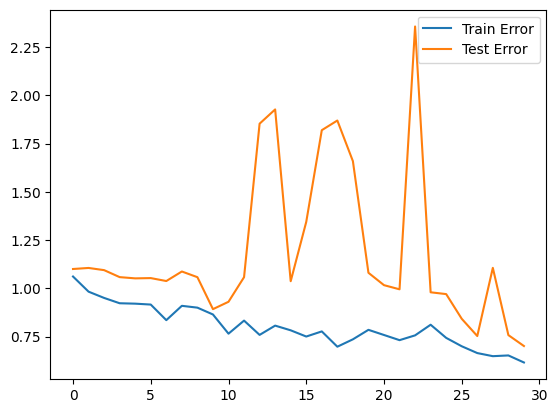

In [ ]:
plt.plot(train_error, label = 'Train Error')
plt.plot(test_error, label = 'Test Error')
plt.legend()
plt.show()

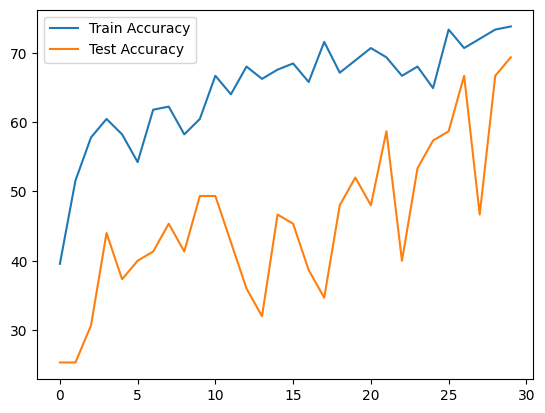

In [ ]:
plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(test_accuracy, label = 'Test Accuracy')
plt.legend()
plt.show()